In [39]:
!nvidia-smi

Fri Aug 18 17:37:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.73       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   38C    P5    25W / 290W |   1041MiB /  8192MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
!pip install -q -U watermark

In [41]:
!pip install -qq transformers

In [42]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

numpy       : 1.25.2
pandas      : 2.0.3
torch       : 2.0.1
transformers: 4.31.0



In [43]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [44]:
df = pd.read_csv("reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,145aacbc-c5e4-47c5-85f5-e253f1f319f2,Filipe Oliveira,https://play-lh.googleusercontent.com/a-/AD_cM...,Experiência horrível. O app parou de funcionar...,1,291,0.107.1,2022-02-05 12:40:00,NaN,NaN,0.107.1,most_relevant,br.com.light.ava
1,c3e1a6f1-c80b-44f2-ba88-a129202643b2,Renata Nascimento,https://play-lh.googleusercontent.com/a-/AD_cM...,"Bom dia, o app esta horrível, sempre usei era ...",1,278,1.25,2020-06-18 09:30:14,NaN,NaN,1.25,most_relevant,br.com.light.ava
2,c7562ba4-d59e-49b6-83d7-7dd1b9182ca7,Eduardo Junior,https://play-lh.googleusercontent.com/a-/AD_cM...,"Layout bonito, mas só! No momento em que você ...",1,216,0.107.1,2022-01-04 19:16:25,"Oi, Eduardo!\n\nObrigada pela sugestão de melh...",2022-01-10 14:42:39,0.107.1,most_relevant,br.com.light.ava
3,e1cbaf6c-6a32-4ba1-bdd3-160d795b80da,Neide Silva,https://play-lh.googleusercontent.com/a/AAcHTt...,Aplicativo horrível! Uma empresa séria que se ...,1,2,3.4,2023-05-28 13:21:09,NaN,NaN,3.4,most_relevant,br.com.light.ava
4,308b8f74-7433-4b5f-85cc-e364917ca06b,Marcos Ivo,https://play-lh.googleusercontent.com/a-/AD_cM...,"Que app horrível!!! Não sai da tela inicial, f...",1,1,3.4,2023-07-11 15:45:31,NaN,NaN,3.4,most_relevant,br.com.light.ava


In [45]:
df.shape

(66456, 13)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66456 entries, 0 to 66455
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              66456 non-null  object
 1   userName              66456 non-null  object
 2   userImage             66456 non-null  object
 3   content               66456 non-null  object
 4   score                 66456 non-null  int64 
 5   thumbsUpCount         66456 non-null  int64 
 6   reviewCreatedVersion  59936 non-null  object
 7   at                    66456 non-null  object
 8   replyContent          19926 non-null  object
 9   repliedAt             19926 non-null  object
 10  appVersion            59936 non-null  object
 11  sortOrder             66456 non-null  object
 12  appId                 66456 non-null  object
dtypes: int64(2), object(11)
memory usage: 6.6+ MB


/home/dominguesg/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


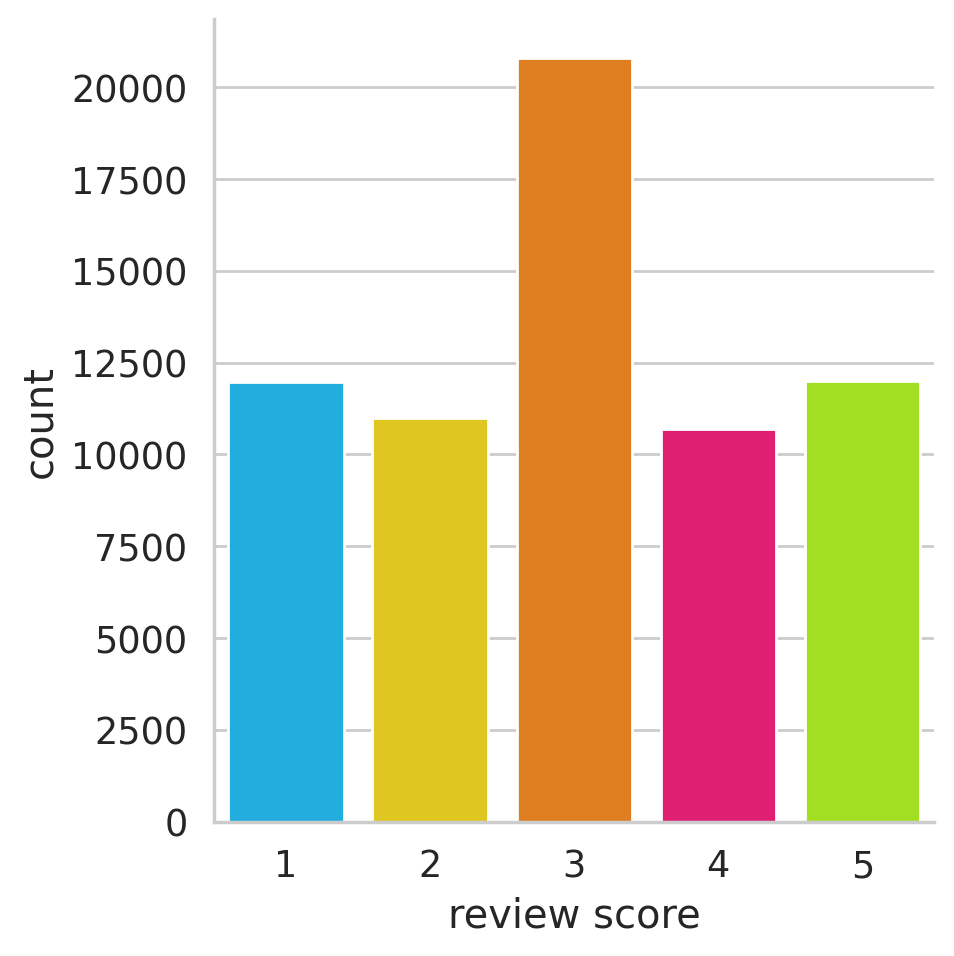

In [47]:
sns.catplot(data=df, kind='count', x='score')
plt.xlabel('review score');

In [48]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [49]:
class_names = ['negative', 'neutral', 'positive']

/home/dominguesg/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


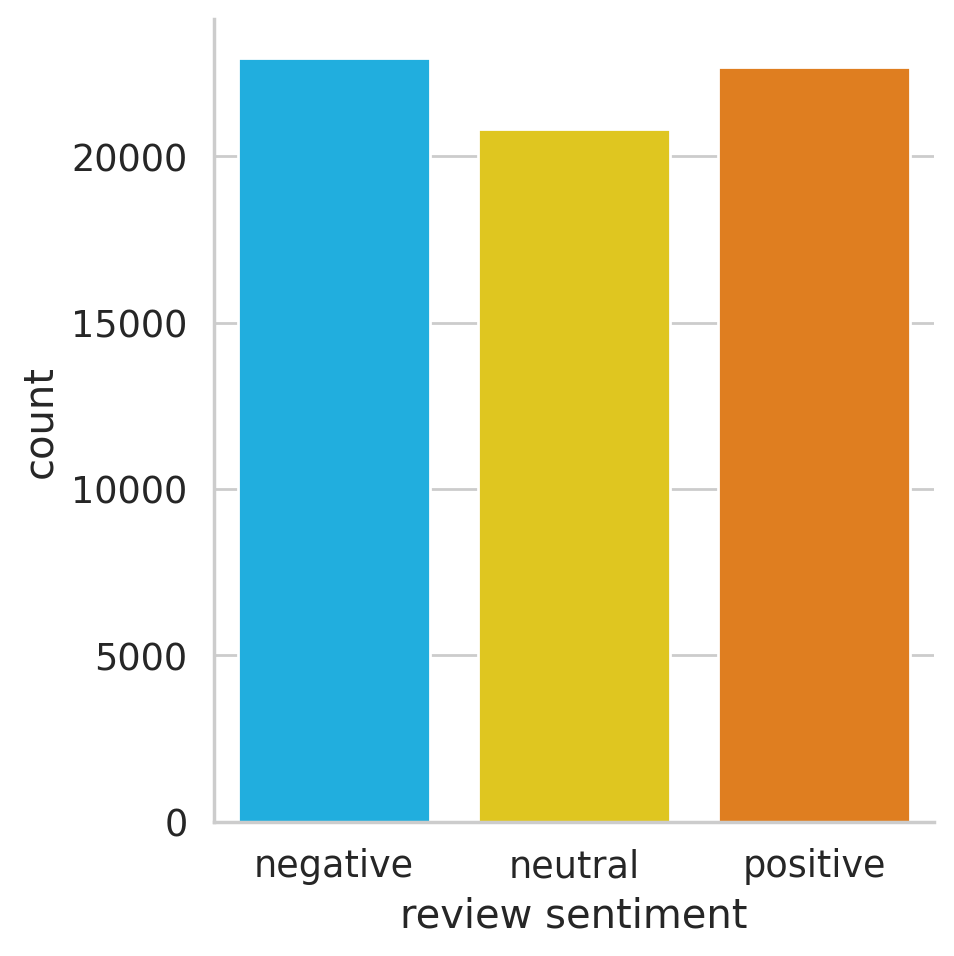

In [50]:
ax = sns.catplot(data=df, kind='count', x='sentiment')
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

# Pre-processamento

In [51]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

In [52]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [53]:
sample_txt = 'Qual foi a última vez que saí de casa? Estou preso em casa por 2 semanas.'

In [54]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Qual foi a última vez que saí de casa? Estou preso em casa por 2 semanas.
   Tokens: ['Qual', 'foi', 'a', 'última', 'vez', 'que', 'sa', '##í', 'de', 'casa', '?', 'Est', '##ou', 'preso', 'em', 'casa', 'por', '2', 'semanas', '.']
Token IDs: [13082, 262, 123, 2338, 576, 179, 629, 22306, 125, 1105, 136, 9009, 203, 5139, 173, 1105, 240, 245, 3765, 119]


In [55]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [56]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [57]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [58]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [59]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  #padding='longest',
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [60]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101, 13082,   262,   123,  2338,   576,   179,   629, 22306,   125,
         1105,   136,  9009,   203,  5139,   173,  1105,   240,   245,  3765,
          119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [61]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Qual',
 'foi',
 'a',
 'última',
 'vez',
 'que',
 'sa',
 '##í',
 'de',
 'casa',
 '?',
 'Est',
 '##ou',
 'preso',
 'em',
 'casa',
 'por',
 '2',
 'semanas',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [62]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/tmp/ipykernel_26671/1971794795.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


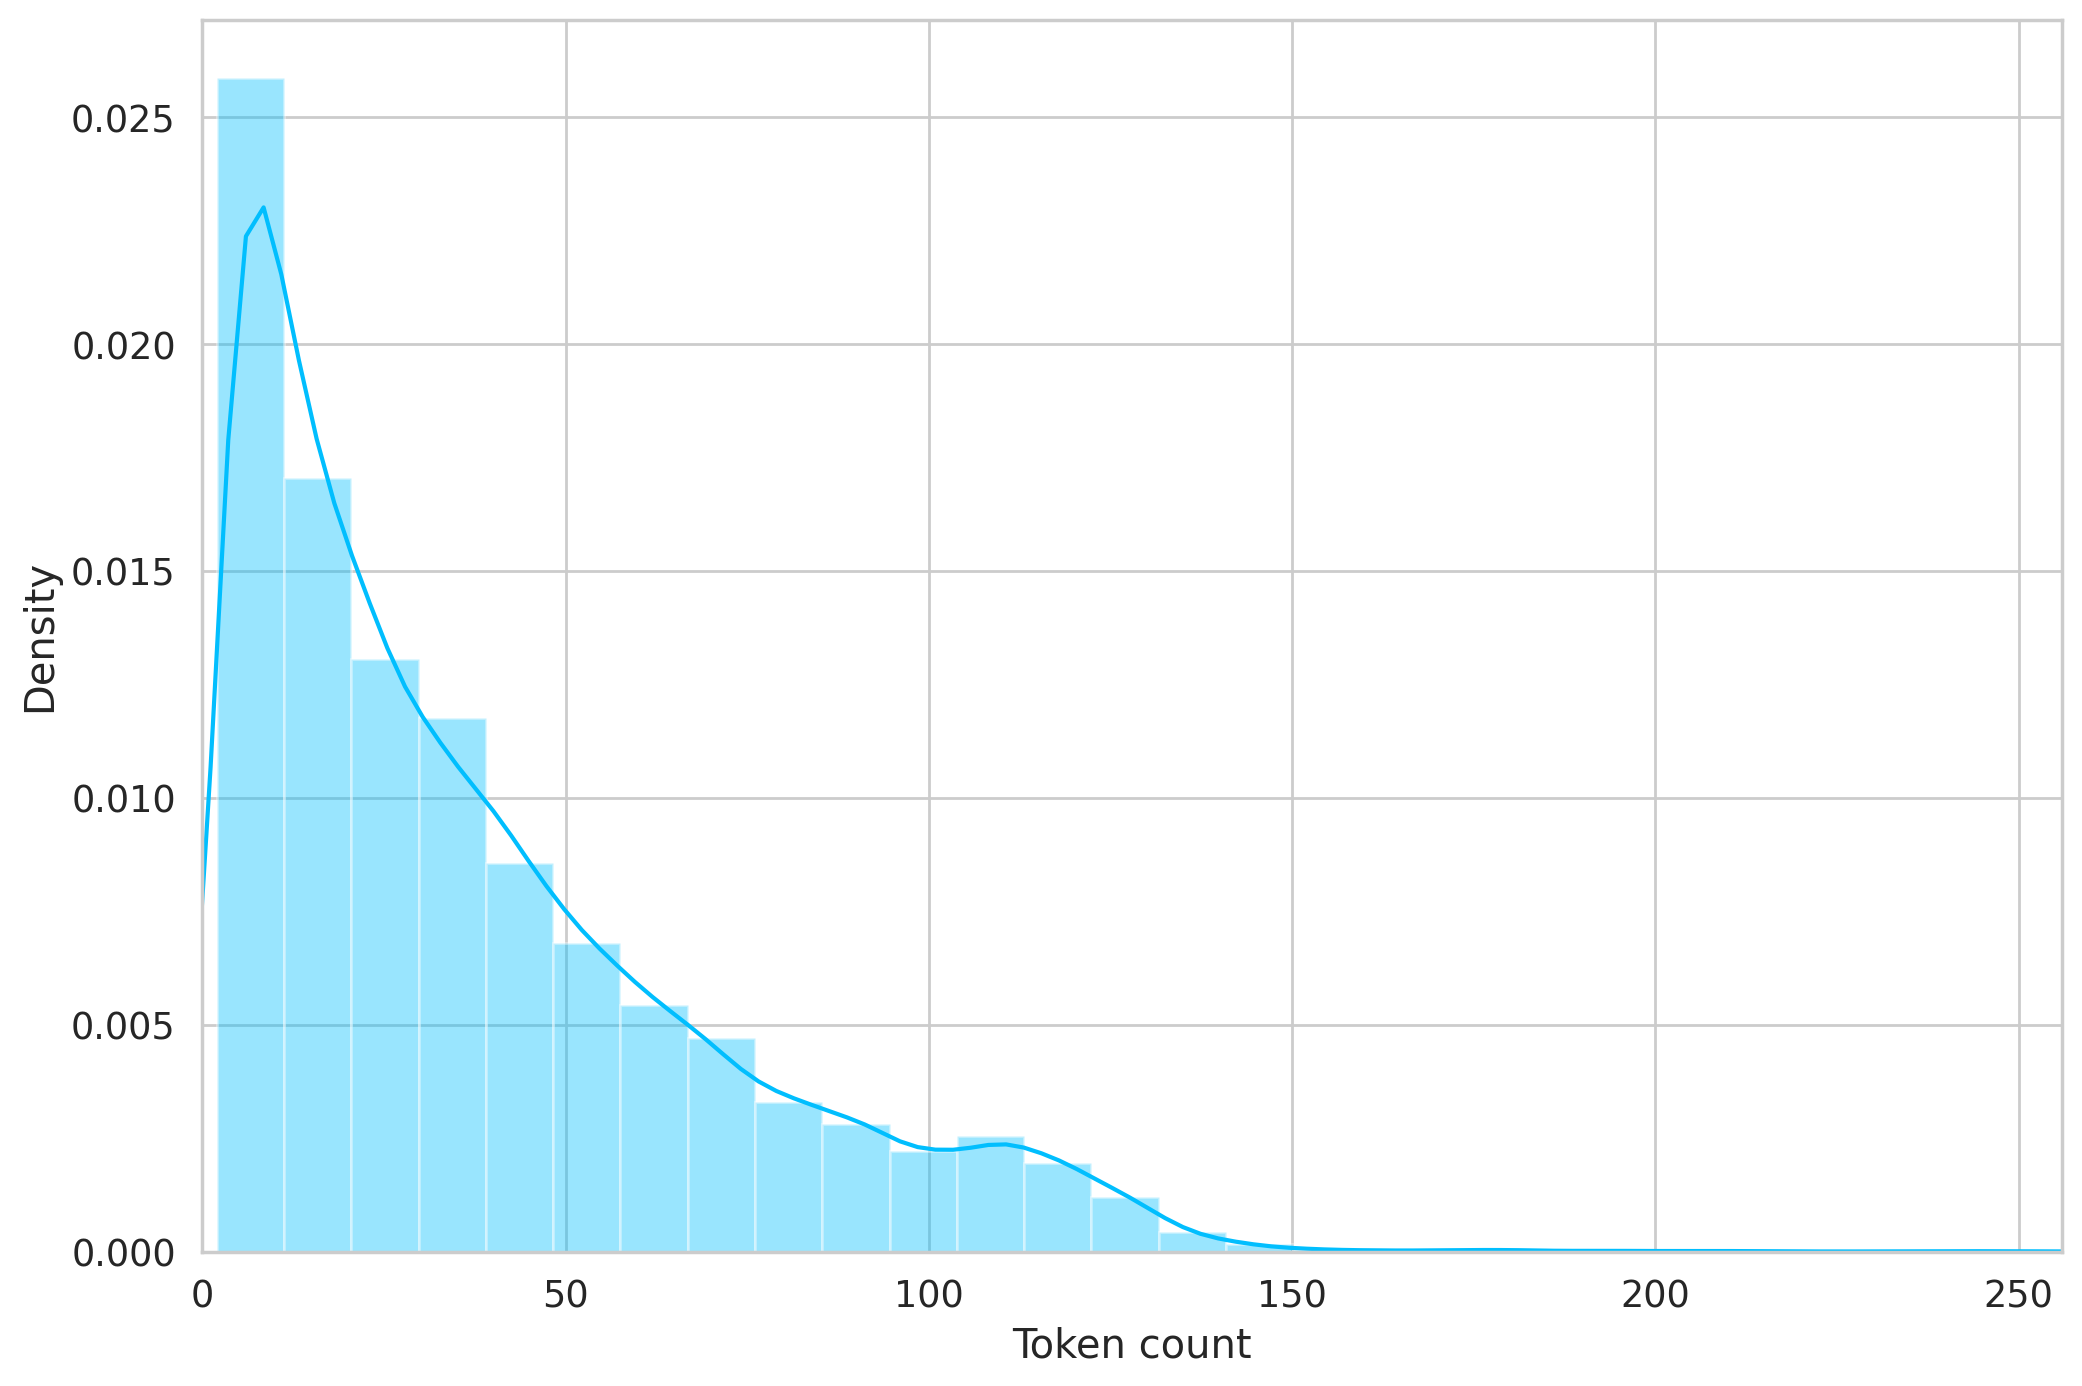

In [63]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [64]:
MAX_LEN = 150

In [65]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #padding='longest',
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [66]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [67]:
df_train.shape, df_val.shape, df_test.shape

((59810, 14), (3323, 14), (3323, 14))

In [68]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [69]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [70]:
len(train_data_loader)

3739

In [71]:
data = next(iter(train_data_loader))
data.keys()

/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [72]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [73]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [74]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [75]:
bert_model.config.hidden_size

768

In [76]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [77]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [78]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


In [79]:
type(attention_mask)

torch.Tensor

In [80]:
type(input_ids)

torch.Tensor

In [81]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3757, 0.2990, 0.3253],
        [0.4565, 0.3058, 0.2378],
        [0.3547, 0.3066, 0.3387],
        [0.4078, 0.2749, 0.3173],
        [0.3811, 0.2730, 0.3459],
        [0.4030, 0.3179, 0.2790],
        [0.3526, 0.2939, 0.3534],
        [0.4145, 0.2446, 0.3409],
        [0.4402, 0.2463, 0.3135],
        [0.3889, 0.3176, 0.2935],
        [0.5267, 0.2419, 0.2314],
        [0.4335, 0.2450, 0.3215],
        [0.3971, 0.2500, 0.3528],
        [0.3919, 0.2904, 0.3176],
        [0.5150, 0.2232, 0.2618],
        [0.4046, 0.3109, 0.2845]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [82]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/home/dominguesg/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [83]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [84]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Epoch 1/10
----------


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Train loss 0.7008229139958132 accuracy 0.6894499247617455


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Val   loss 0.6401813306774085 accuracy 0.721336142040325

Epoch 2/10
----------


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Train loss 0.5545247066955327 accuracy 0.7714763417488715


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Val   loss 0.6330875095982964 accuracy 0.7448089076136022

Epoch 3/10
----------


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Train loss 0.4219452371961789 accuracy 0.840043470991473


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Val   loss 0.7135236407451045 accuracy 0.7664760758350888

Epoch 4/10
----------


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Train loss 0.3253330165198619 accuracy 0.8862731984617956


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Val   loss 0.8261336824641778 accuracy 0.7845320493529944

Epoch 5/10
----------


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Train loss 0.26684594433212927 accuracy 0.9138438388229393


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Val   loss 0.9260880976754169 accuracy 0.7923563045440867

Epoch 6/10
----------


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Train loss 0.2250840866147207 accuracy 0.9295268349774285


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Val   loss 0.9987800472478668 accuracy 0.7923563045440867

Epoch 7/10
----------


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Train loss 0.1918023007651121 accuracy 0.9438221033272028


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Val   loss 1.1152404700249183 accuracy 0.7995786939512489

Epoch 8/10
----------


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Train loss 0.1618532098959083 accuracy 0.9527838154154824


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Val   loss 1.2321479990608237 accuracy 0.796569365031598

Epoch 9/10
----------


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Train loss 0.13918581640838812 accuracy 0.959304464136432


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Val   loss 1.2748765302167158 accuracy 0.7947637676798075

Epoch 10/10
----------


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Train loss 0.12351938734718033 accuracy 0.9635345259989968


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

Val   loss 1.2798535671648166 accuracy 0.7950647005717726



TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

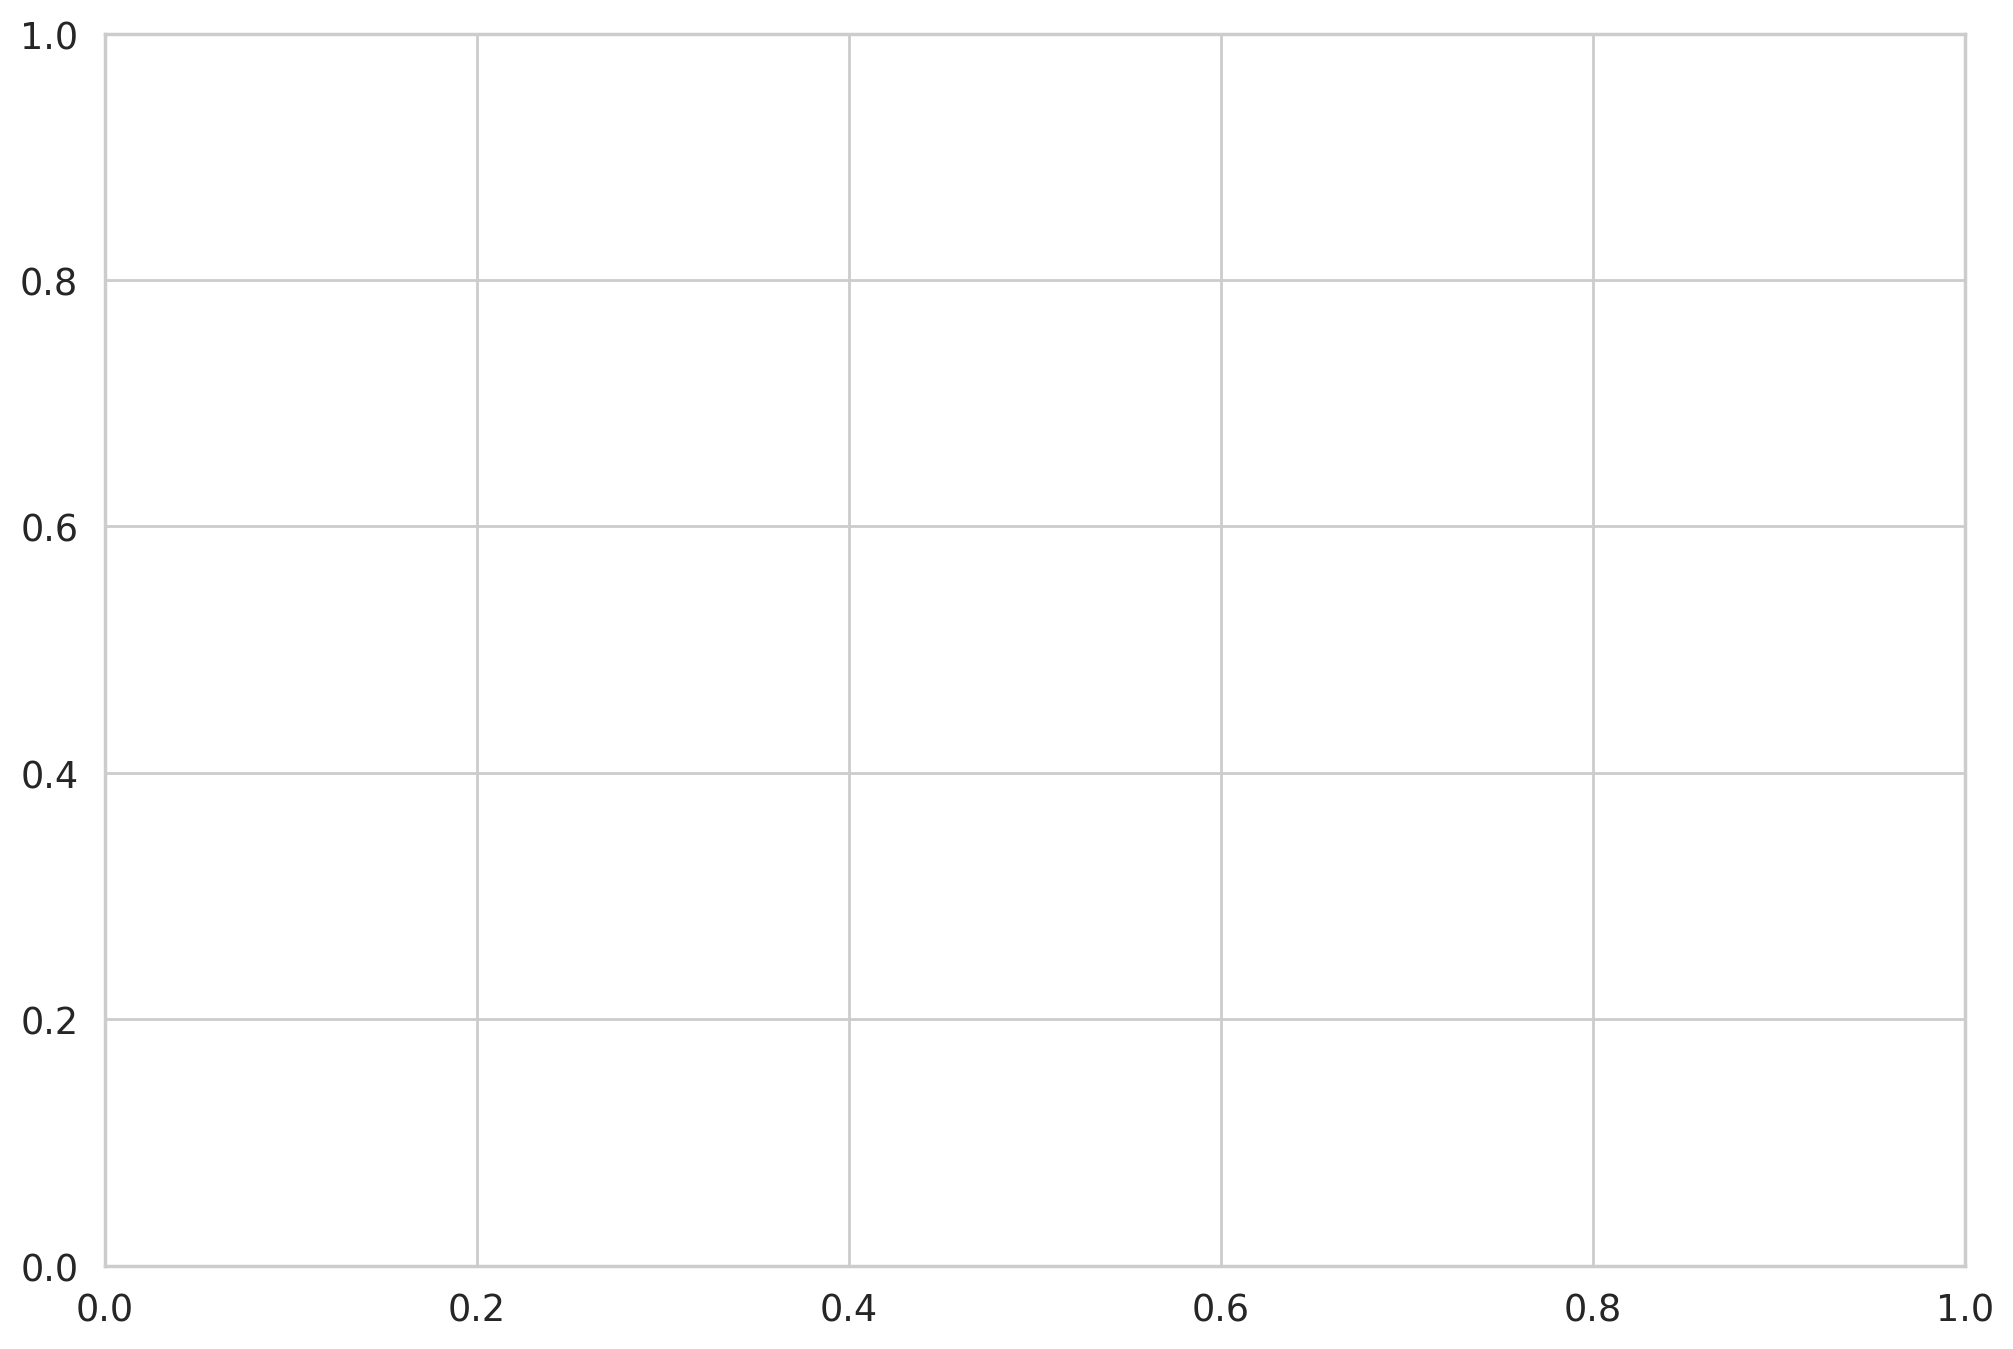

In [85]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc


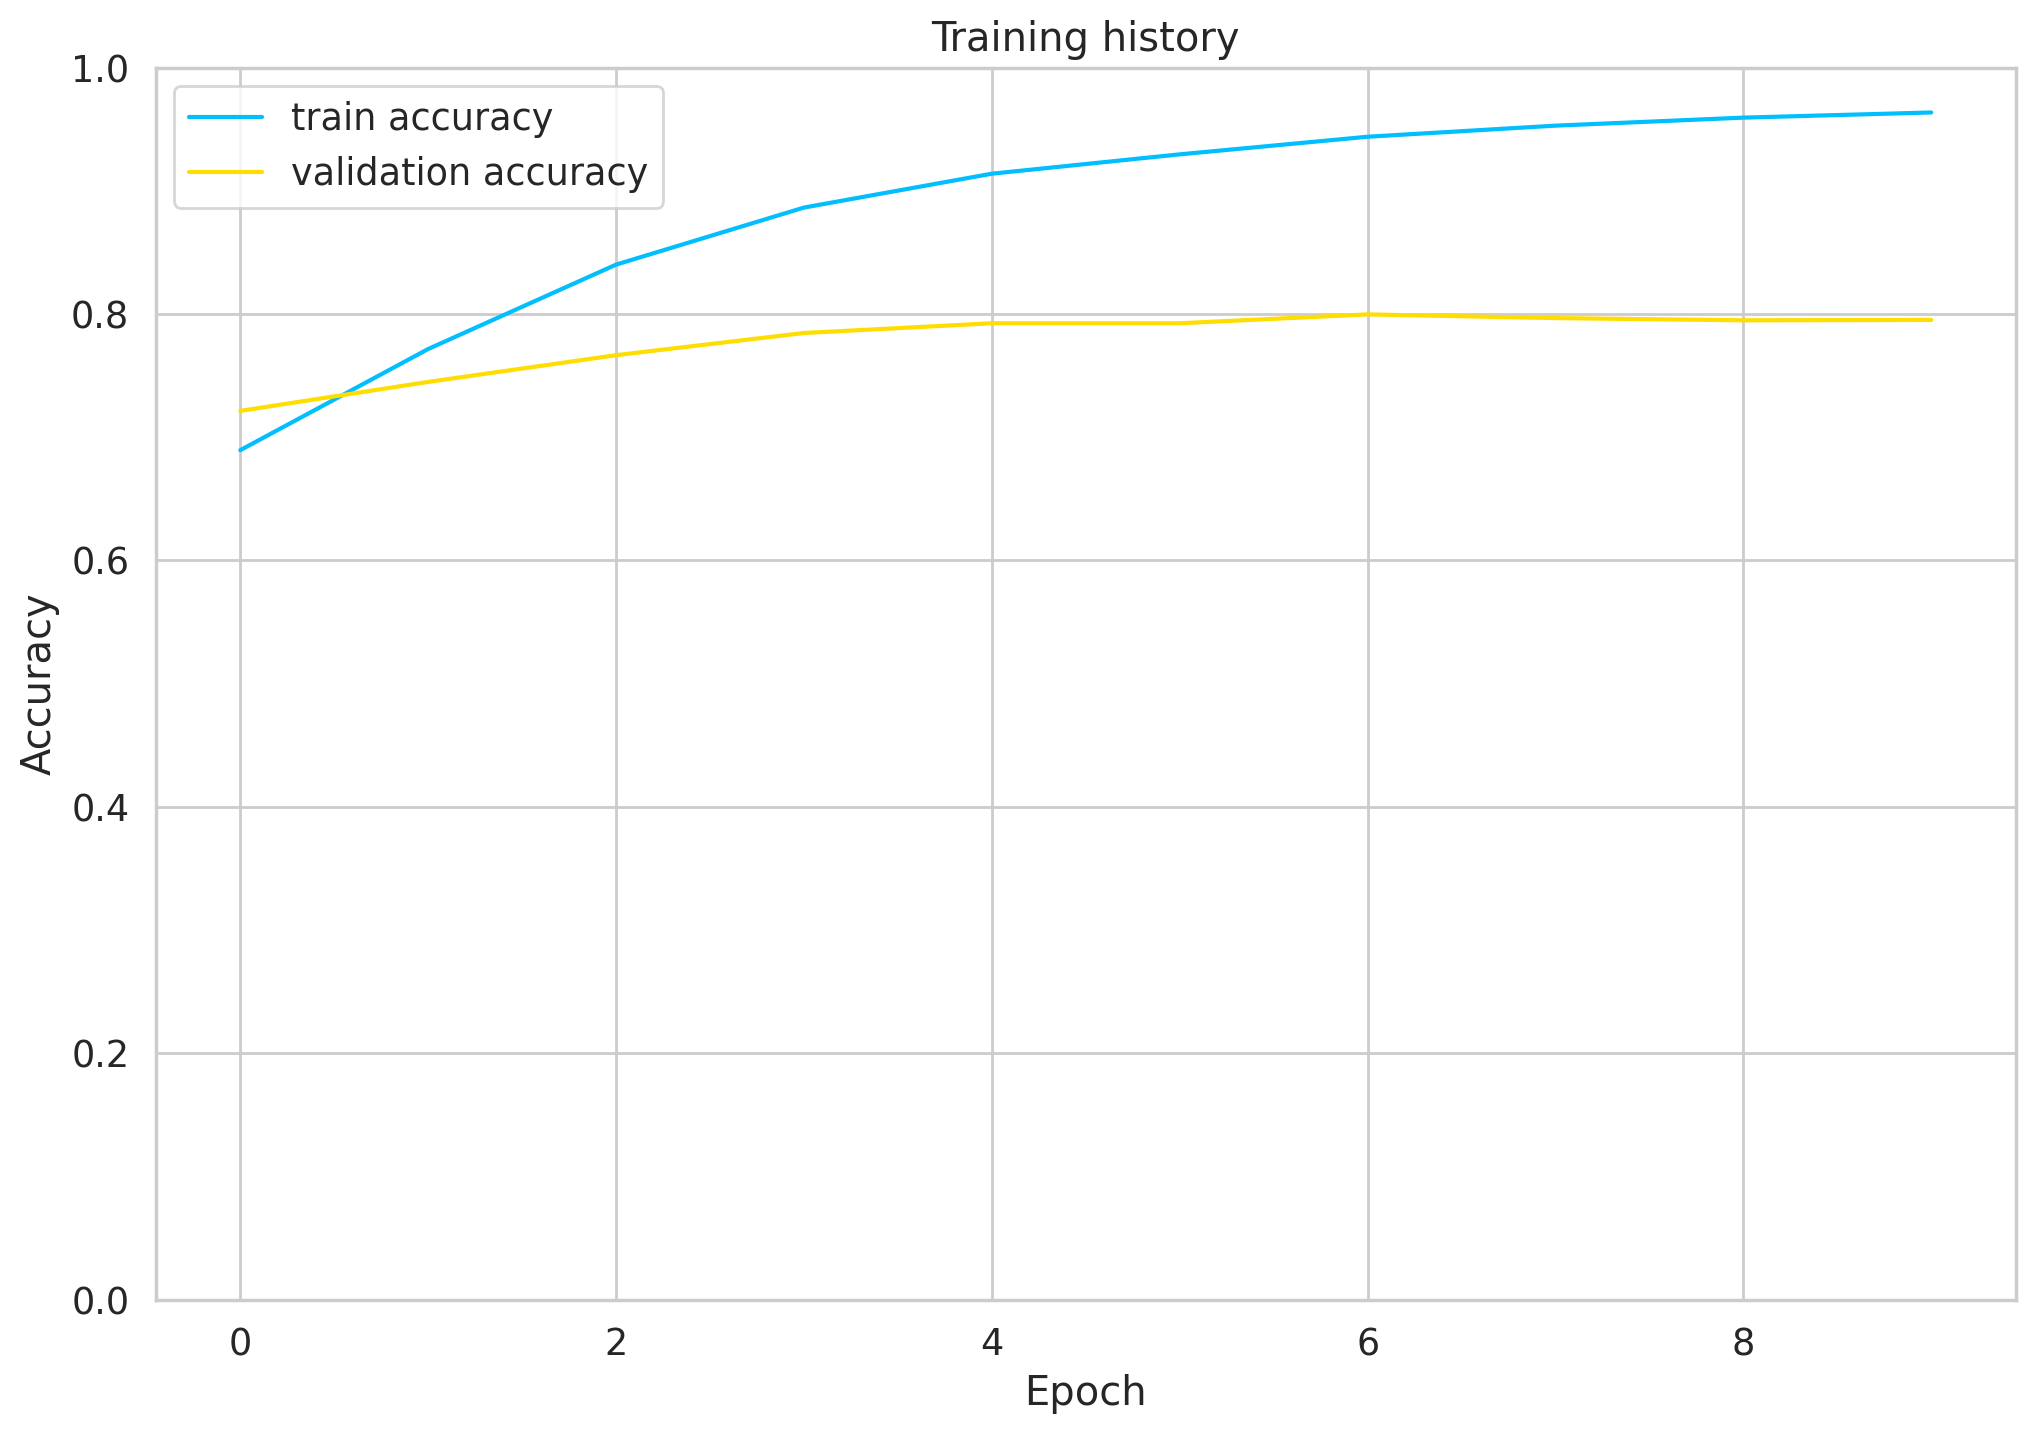

In [87]:
# dados1 = {
# 'train_acc': [0.6447, 0.7680, 0.8645, 0.9120, 0.9408, 0.9565, 0.9669, 0.9742, 0.9781, 0.9784],
# 'train_loss': [0.7817344548866937, 0.5685535880957583, 0.39160531521529746, 0.2761664365825709, 0.20463237862981928, 0.15911034505667263, 0.1192154210904463, 0.0948445917622992, 0.0820107631258763, 0.07412172160040523],
# 'val_acc': [0.6722, 0.7074, 0.7185, 0.7185, 0.7315, 0.7370, 0.7278, 0.7370, 0.7241, 0.7222],
# 'val_loss': [0.7169850196908502, 0.7329929295708152, 0.8680587463519153, 1.0492213613846724, 1.2776514204109417, 1.4349745792501114, 1.5805009813869701, 1.656259447336197, 1.7987813265884625, 1.8015463404795702]
# }

# dados2 = {
# 'train_acc': [0.8404, 0.9217, 0.9553, 0.9668, 0.9774, 0.9809, 0.9821, 0.9848, 0.9857, 0.9867], 
# 'train_loss': [0.45188328594131716, 0.25290511693119216, 0.16589857561944213, 0.12761202722762582, 0.09072439466925923, 0.07174617887051825, 0.06360042245681766, 0.05378078923977706, 0.04967683794903247, 0.04259902020466574], 
# 'val_acc': [0.7241, 0.7093, 0.7333, 0.7463, 0.7259, 0.7148, 0.7333, 0.7315, 0.7278, 0.7185], 
# 'val_loss': [0.9236580961767364, 1.3664893827894156, 1.56394765164484, 1.5679735568735529, 1.82847398519516, 1.9171697580639053, 1.9034794126363361, 1.9412972515120226, 1.9371832626707413, 1.9803748516475452]
# }

dados = {
'train_acc': [0.6894, 0.7715, 0.8400, 0.8863, 0.9138, 0.9295, 0.9438, 0.9528, 0.9593, 0.9635], 
'train_loss': [0.7008229139958132, 0.5545247066955327, 0.4219452371961789, 0.3253330165198619, 0.26684594433212927, 0.2250840866147207, 0.1918023007651121, 0.1618532098959083, 0.13918581640838812, 0.12351938734718033], 
'val_acc': [0.7213, 0.7448, 0.7665, 0.7845, 0.7924, 0.7924, 0.7996, 0.7966, 0.7948, 0.7951], 
'val_loss': [0.6401813306774085, 0.6330875095982964, 0.7135236407451045, 0.8261336824641778, 0.9260880976754169, 0.9987800472478668, 1.1152404700249183, 1.2321479990608237, 1.2748765302167158, 1.2798535671648166]
}

plt.plot(dados['train_acc'], label='train accuracy')
plt.plot(dados['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


In [88]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

0.7956665663557028

In [89]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [90]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to

In [91]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.82      0.81      0.82      1154
     neutral       0.71      0.72      0.71      1030
    positive       0.84      0.85      0.85      1139

    accuracy                           0.80      3323
   macro avg       0.79      0.79      0.79      3323
weighted avg       0.80      0.80      0.80      3323



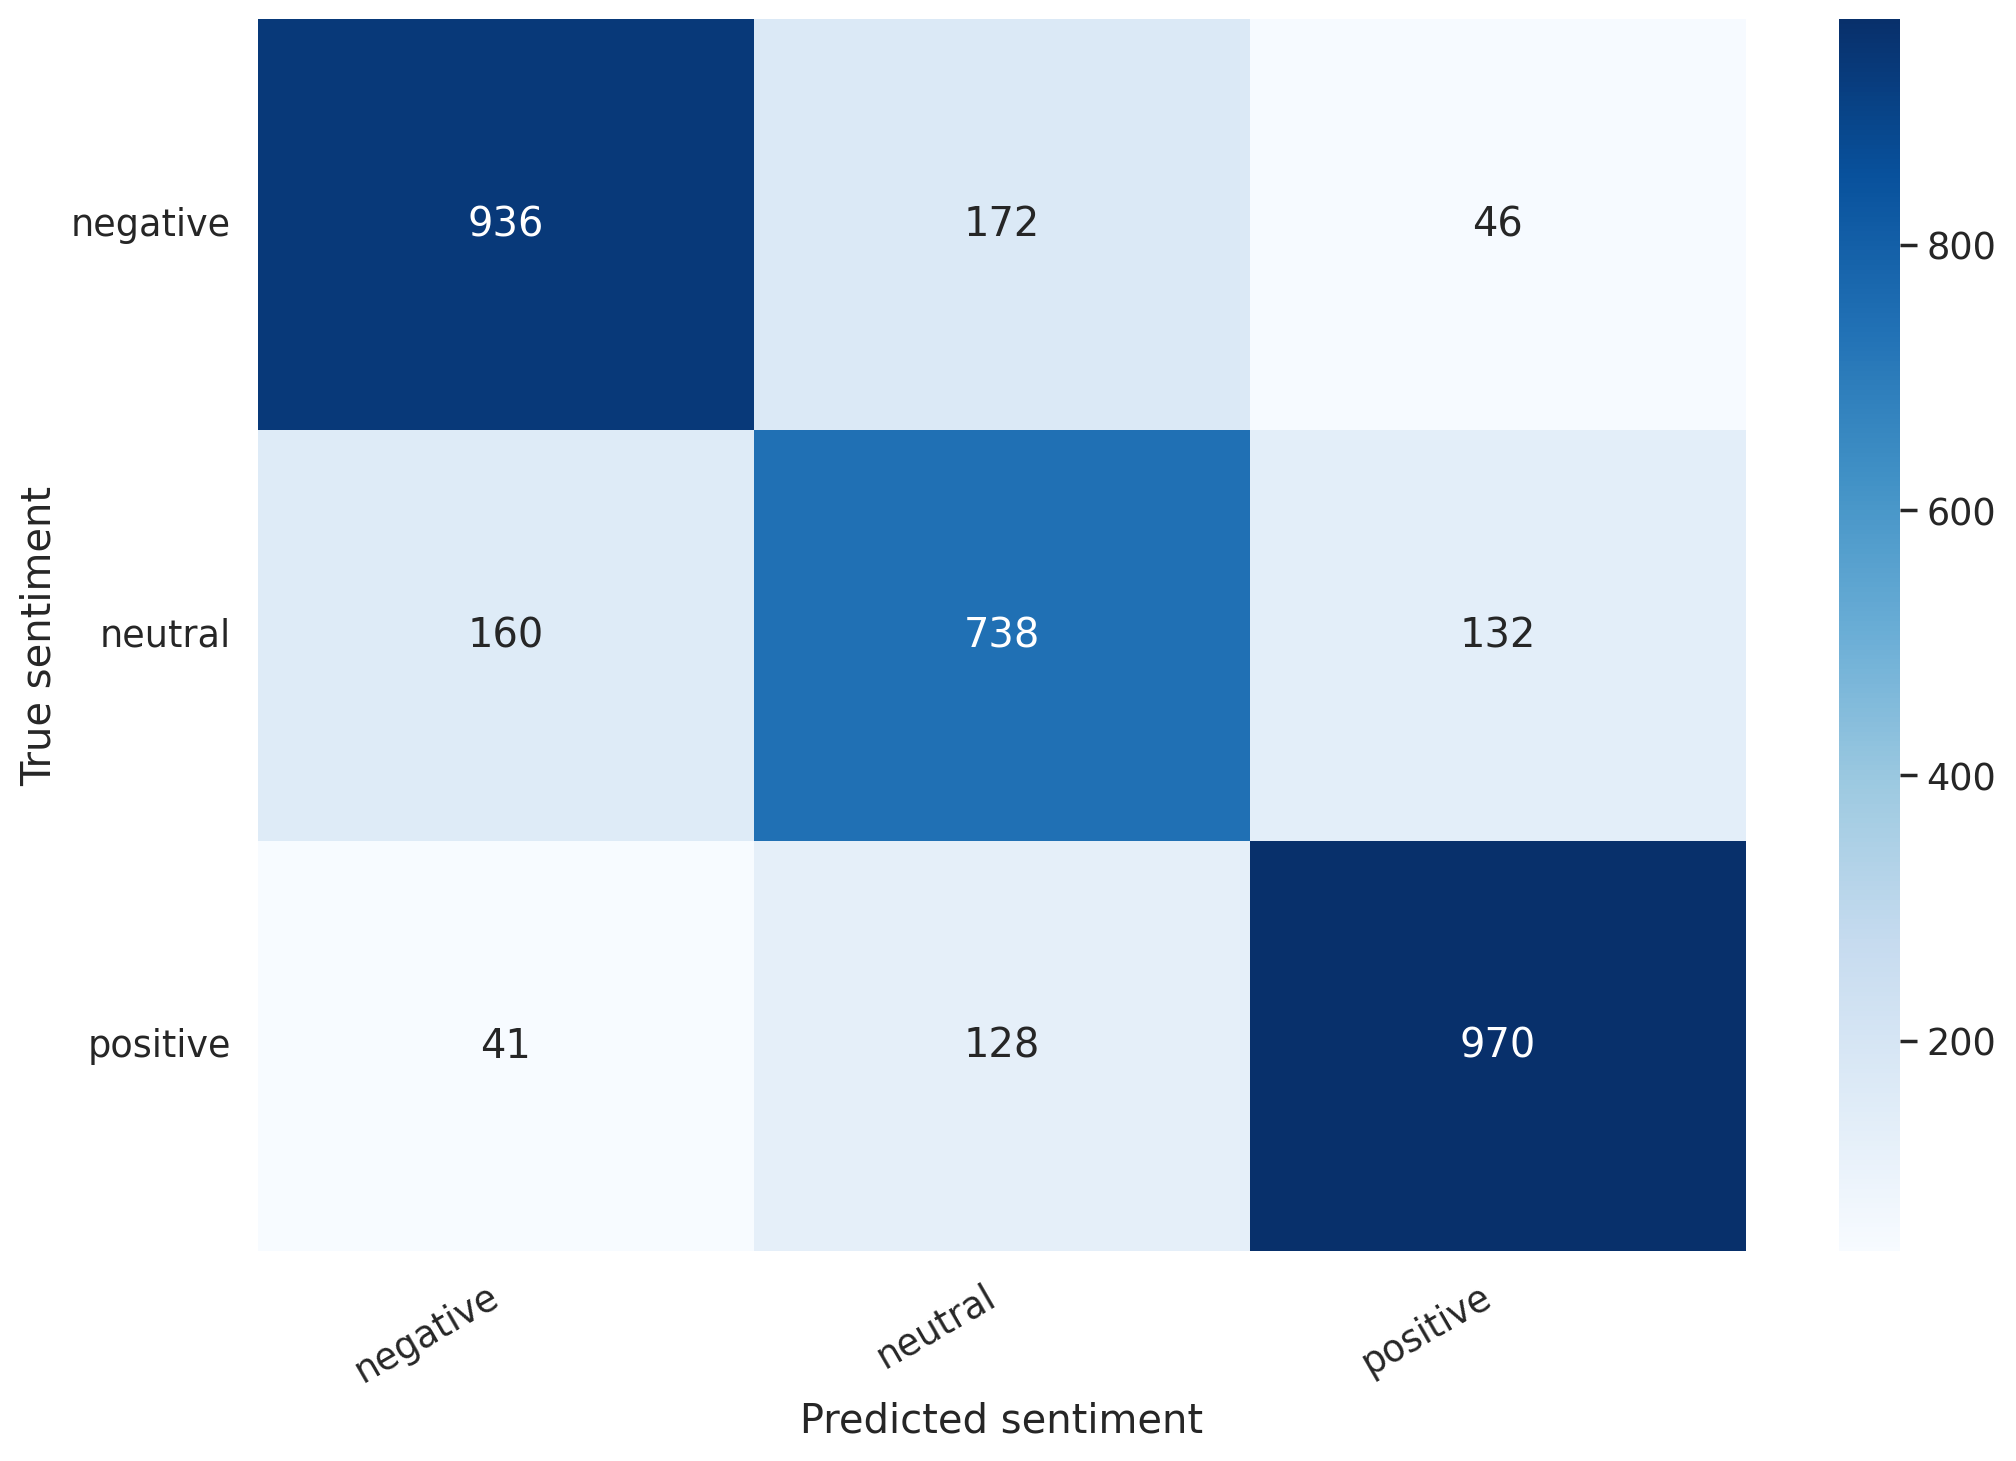

In [92]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

foi muito bom eu preciso mesmo e da segunda via

True sentiment: positive


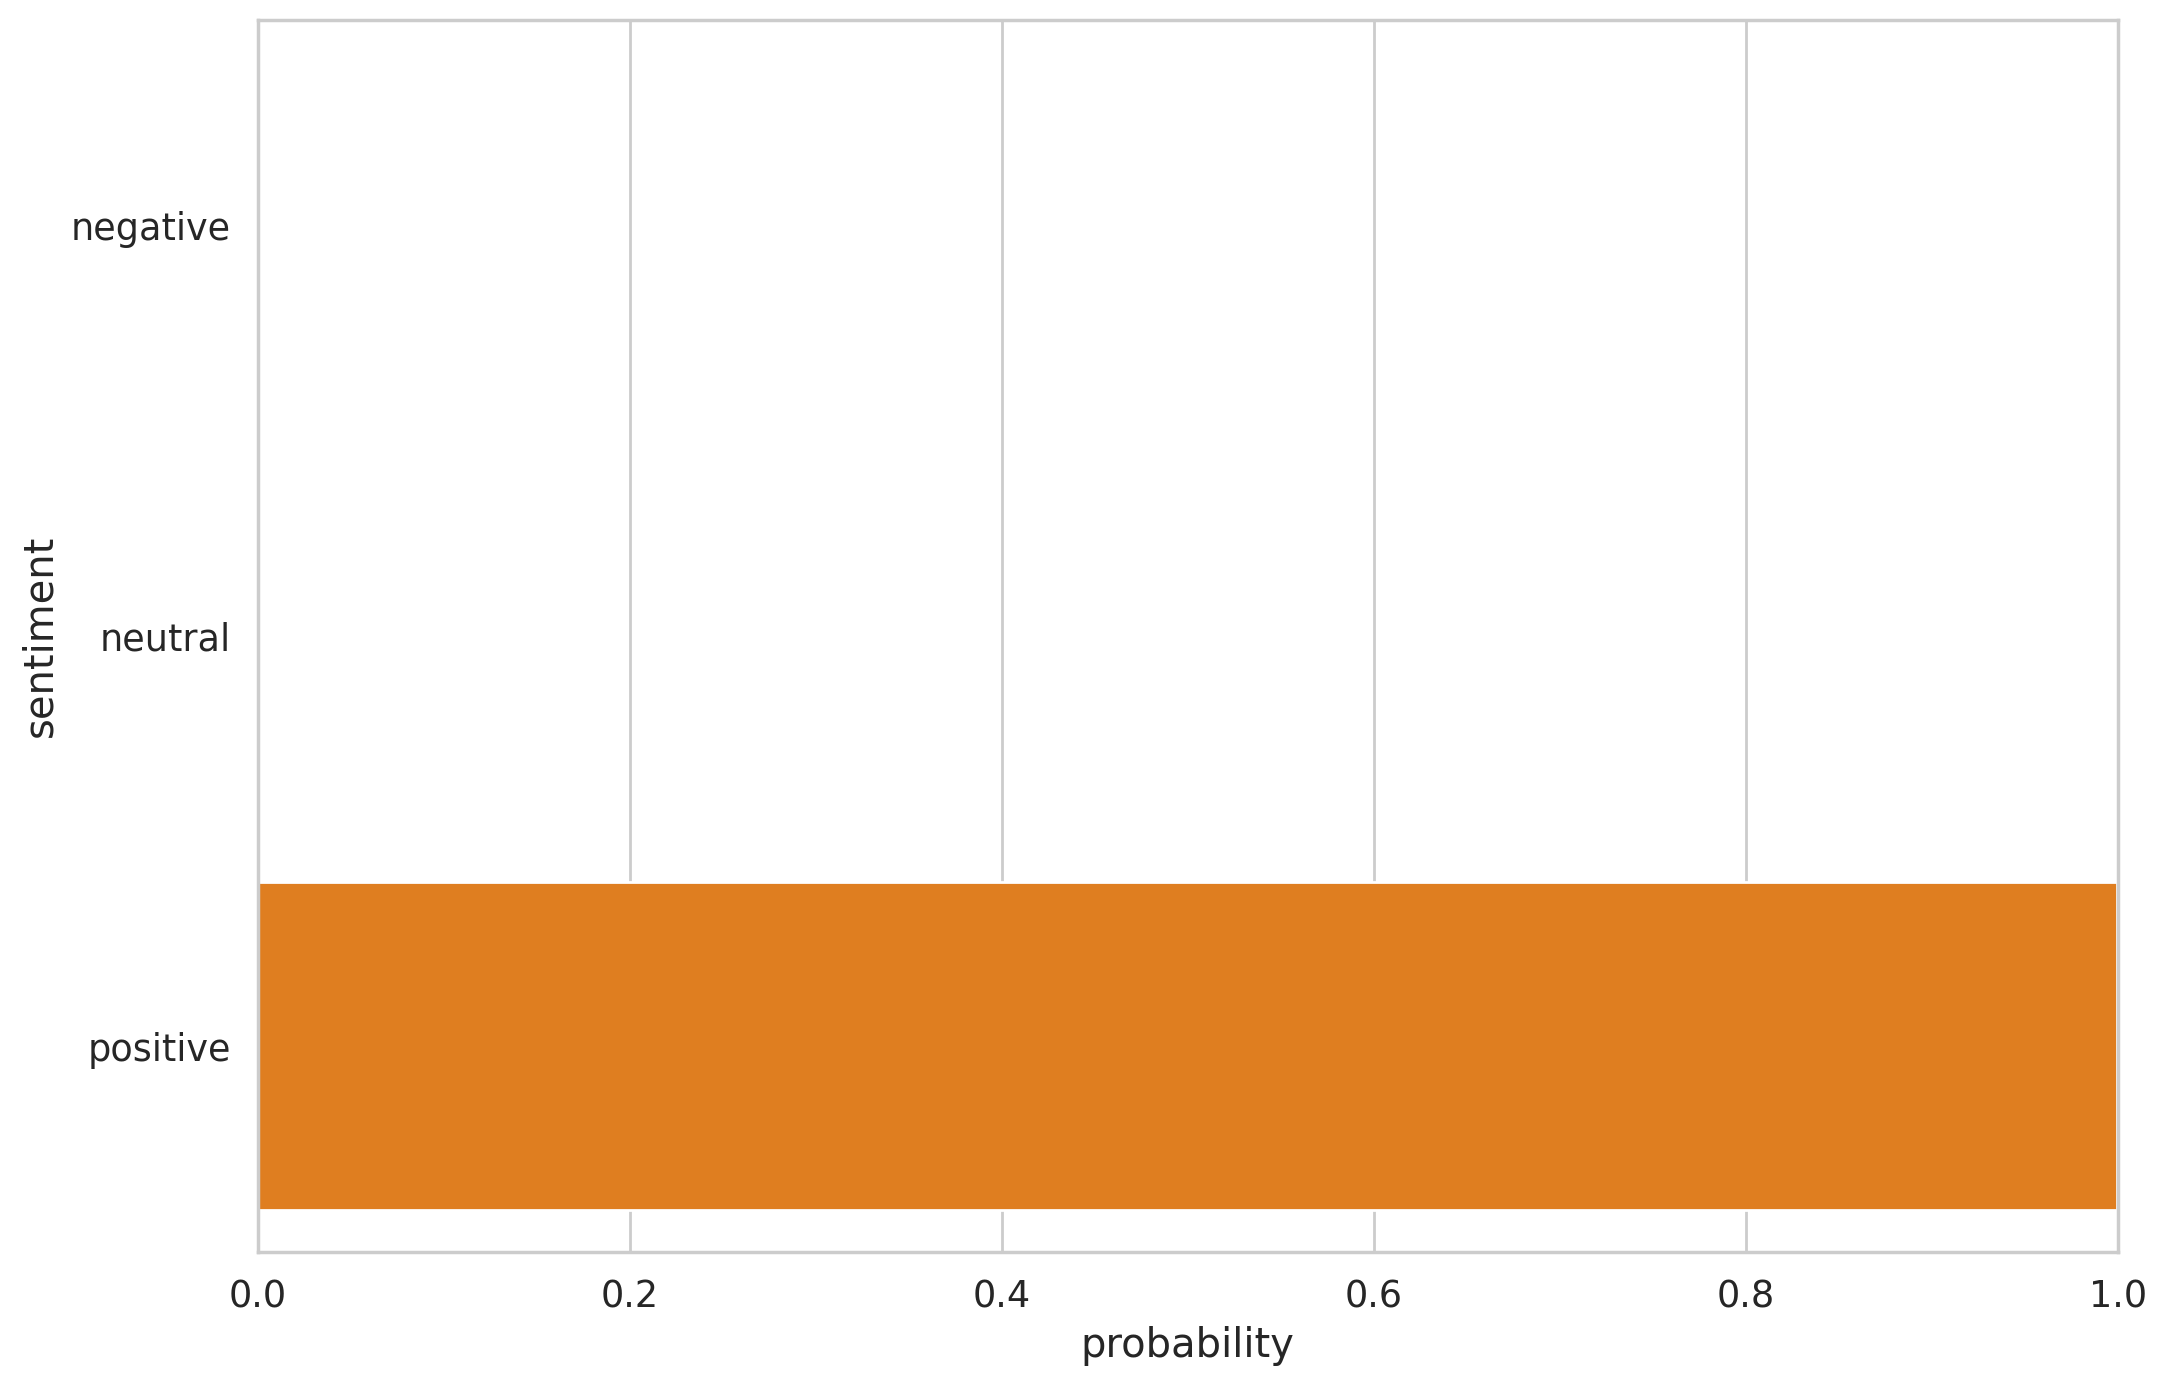

In [99]:
idx = 20

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [111]:
review_text = "O jogo é bom mais o suporte é péssimo, fiz uma compra de um pacote e o mesmo sumiu da conta no mesmo dia, já abri reclamação no suporte ao cliente, porém o mesmo só aceita inglês, e é horrível o atendimento. ID reclamação: 2458610 eu não pretendo voltar a comprar no jogo por conta desse problema, tenho provas e prints da compra feita..."

encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: O jogo é bom mais o suporte é péssimo, fiz uma compra de um pacote e o mesmo sumiu da conta no mesmo dia, já abri reclamação no suporte ao cliente, porém o mesmo só aceita inglês, e é horrível o atendimento. ID reclamação: 2458610 eu não pretendo voltar a comprar no jogo por conta desse problema, tenho provas e prints da compra feita...
Sentiment  : negative


/home/dominguesg/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
